In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
from utils.process import Assemble
assemble = Assemble()
from utils.process import Categorize
categorize = Categorize()
from utils.generate import Generate
generate = Generate()
from utils.train import Create, Build
create = Create()
from utils.process import Preprocess
precprocess = Preprocess()

In [3]:
df = pd.read_csv('./data/Clean_Dataset.csv')

In [1]:
#HEYHEY

# Data Prep

In [129]:
df['path'] = df['source_city'] + ' ' + df['destination_city']

In [130]:
df['time'] = df['departure_time'] + ' ' + df['arrival_time']

In [131]:
df.replace({'Economy':0,'Business':1}, inplace=True)

In [132]:
df = df.drop(['Unnamed: 0','flight','source_city','destination_city','departure_time','arrival_time'], axis=1)

### days_left Categorization

In [133]:
days_left_ranges = generate.generate_numerical_ranges(df.days_left, [2,5,10,18])
days_left_dict = categorize.categorize_numerical_variable(df.days_left, days_left_ranges)
df['days_left_category'] = df['days_left'].map(days_left_dict)

### path Categorization

In [134]:
start = df.groupby('path').mean()['price'].min()
finish = df.groupby('path').mean()['price'].max()

In [135]:
path_ranges = generate.generate_categorical_ranges(3, start, finish)
path_ranges

[range(17243, 19855), range(19855, 22467), range(22467, 37619)]

In [136]:
path_group = df.groupby('path').mean()['price']
path_dict = categorize.categorize_categorical_variable(path_group, path_ranges)
df['path_category'] = df['path'].map(path_dict)

### duration Categorization

In [137]:
duration_ranges = generate.generate_numerical_ranges(df.duration, [5,18,28])
duration_dict = categorize.categorize_numerical_variable(df.duration, duration_ranges)
df['duration_category']=df['duration'].map(duration_dict)

### time Categorization

In [138]:
start = df.groupby('time').mean()['price'].min()
finish = df.groupby('time').mean()['price'].max()

In [139]:
time_ranges = generate.generate_categorical_ranges(3, start, finish)
time_ranges

[range(4288, 13333), range(13333, 22378), range(22378, 47135)]

In [140]:
time_group = df.groupby('time').mean()['price']
time_dict = categorize.categorize_categorical_variable(time_group, time_ranges)
df['time_category'] = df['time'].map(time_dict)

# All Data

## All Data 1

In [116]:
df_all1 = df.drop(['days_left','duration','path','time'], axis=1)

## All Data 2

In [117]:
df_all2 = df.drop(['days_left_category','duration_category','path_category','time_category'], axis=1)

# Economy Business Split

In [94]:
df_economy = df[df['class']==0]
df_economy = df_economy.drop('class',axis=1)
df_business = df[df['class']==1]
df_business = df_business.drop('class',axis=1)

## Economy 1

In [97]:
df_economy1 = df_economy.drop(['days_left','duration','path','time'], axis=1)

## Economy 2

In [98]:
df_economy2 = df_economy.drop(['days_left_category','path_category','duration_category','time_category'], axis=1)

## Economy 3

In [100]:
df_economy3 = df_economy.drop(['stops','path','duration_category','days_left_category','time_category'], axis=1)

## Business 1

In [101]:
df_business1 = df_business.drop(['days_left','duration','path','time','days_left_category'], axis=1)
df_business1.replace({'zero':0,'one':1,'two_or_more':2}, inplace=True)

## Business 2

In [109]:
df_business2 = df_business.drop(['days_left_category','path_category','duration_category','time_category'], axis=1)
df_business2.replace({'zero':0,'one':1,'two_or_more':2}, inplace=True)

## Business 3

In [110]:
df_business3 = df_business.drop(['days_left','days_left_category','path','time','duration'], axis=1)

# Regression Models Dictionary

In [10]:
# df , split data , models , predictions

In [120]:
economy_regression_test_dict = {}
business_regression_test_dict = {}
all_regression_test_dict = {}

In [121]:
economy_regression_test_dict['data'] = {'E1':df_economy1, 'E2':df_economy2, 'E3':df_economy3}
business_regression_test_dict['data'] = {'B1':df_business1, 'B2':df_business2, 'B3':df_business3}
all_regression_test_dict['data'] = {'A1':df_all1, 'A2':df_all2}

# Model Training

In [2]:
models = [['LR1', {}, 'SFM1', {}],
          ['RFR1', {'n_estimators': 20, 'criterion':'squared_error'}, 'RFE1', {'n_features_to_select': 3, 'step':1}],
          ['RFR2', {'n_estimators': 20, 'criterion':'poisson'}, 'RFE2', {'n_features_to_select':4, 'step':1}],
          ['RFR3', {'n_estimators': 100, 'criterion':'squared_error'}, 'SKB1', {'k':3}],
          ['RFR4', {'n_estimators': 100, 'criterion':'poisson'}, 'SFS', {'n_features_to_select':3}],
          ['GBR1', {'learning_rate':0.1, 'criterion':'friedman_mse', 'n_estimators':20, 'loss':'squared_error'}, 'SKB1', {'k':3}]
          ]

In [1]:
LogisticRegression = [['LR1', {'penalty':'l2','solver':'lbfgs','multi_class':'auto'}],
                      ['LR2', {'penalty':'l2','solver':'liblinear','multi_class':'ovr'}],
                      ['LR3', {'penalty':'elasticnet','solver':'saga','multi_class':'auto'}],
                      ['LR4', {'penalty':'l1','solver':'liblinear','multi_class':'auto'}],
                      ['LR5', {'penalty':'l2','solver':'sag','multi_class':'ovr'}],
                     ]

In [2]:
DecisionTreeClassifier = [['DTC1', {'criterion':'gini','ccp_alpha':0.0}],
                          ['DTC2', {'criterion':'entropy','ccp_alpha':0.0}],
                          ['DTC3', {'criterion':'entropy','ccp_alpha':0.3}],
                          ['DTC4', {'criterion':'log_loss','ccp_alpha':0.4}],
                         ]

In [5]:
RandomForestClassifier = [['RFC1', {'n_estimators': 20, 'criterion':'gini','max_depth':None,'min_samples_split':2,'min_samples_leaf':1,'ccp_alpha':0.0,'oob_score':False}],
                          ['RFC2', {'n_estimators': 20, 'criterion':'entropy','max_depth':None,'min_samples_split':2,'min_samples_leaf':1,'ccp_alpha':0.0,'oob_score':False}],
                          ['RFC3', {'n_estimators': 100, 'criterion':'gini','max_depth':10,'min_samples_split':5,'min_samples_leaf':1,'ccp_alpha':0.0,'oob_score':False}],
                          ['RFC4', {'n_estimators': 100, 'criterion':'log_loss','max_depth':None,'min_samples_split':2,'min_samples_leaf':1,'ccp_alpha':0.0,'oob_score':True}]
                         ]

In [6]:
SupportVectorClassifier = [['SVC1', {'C':1.0,'kernel':'rbf','gamma':'scale','degree':3}],
                           ['SVC2', {'C':2.0,'kernel':'rbf','gamma':'auto','degree':2}],
                           ['SVC3', {'C':1.0,'kernel':'linear','gamma':'scale','degree':3}],
                           ['SVC4', {'C':1.0,'kernel':'poly','gamma':'auto','degree':2}],
                          ]

In [9]:
KNeighborsClassifier = [['KNN1', {'n_neighbors':5,'weights':'uniform','algorithm':'auto','leaf_size':30}],
                        ['KNN2', {'n_neighbors':5,'weights':'distance','algorithm':'ball_tree','leaf_size':30}],
                        ['KNN3', {'n_neighbors':3,'weights':'uniform','algorithm':'kd_tree','leaf_size':50}],
                        ['KNN4', {'n_neighbors':3,'weights':'distance','algorithm':'auto','leaf_size':30}]
                       ]

In [11]:
models = [['LR1', {'penalty':'l2','solver':'lbfgs','multi_class':'auto'}],
          ['LR2', {'penalty':'l2','solver':'liblinear','multi_class':'ovr'}],
          ['DTC1', {'criterion':'gini','ccp_alpha':0.0}],
          ['DTC2', {'criterion':'entropy','ccp_alpha':0.0}],
          ['RFC1', {'n_estimators': 20, 'criterion':'gini','max_depth':None,'min_samples_split':2,'min_samples_leaf':1,'ccp_alpha':0.0,'oob_score':False}],
          ['RFC2', {'n_estimators': 20, 'criterion':'entropy','max_depth':None,'min_samples_split':2,'min_samples_leaf':1,'ccp_alpha':0.0,'oob_score':False}],
          ['SVC1', {'C':1.0,'kernel':'rbf'}],
          ['SVC2', {'C':2.0,'kernel':'rbf'}],
          ['KNN1', {'n_neighbors':5,'weights':'uniform','algorithm':'auto','leaf_size':30}],
          ['KNN2', {'n_neighbors':5,'weights':'distance','algorithm':'ball_tree','leaf_size':30}]
         ]

In [14]:
build = Build(economy_regression_test_dict)

In [15]:
build.build_regression_models(models, 'price')

Training regression model LR1 for E1
Training done!

Training regression model RFR1 for E1
Training done!



In [16]:
economy_regression_test_dict.keys()

dict_keys(['data', 'predictions', 'models'])

In [18]:
economy_regression_test_dict['predictions']

{'E1LR1': array([ 8551.73344509, 10251.86030579,  5015.50447876, ...,
         6518.8800095 ,  3949.71980886,  6984.43687762]),
 'E1RFR1': array([ 6568.  , 10257.25,  4886.4 , ...,  3740.5 ,  5748.75,  5142.85])}

In [15]:
X_train, X_test, y_train, y_test = precprocess.preprocess_test_data(df_economy, 'price')

In [16]:
regressor = train.train_regression_model((X_train, y_train), 'LR')

In [18]:
predictions = regressor.predict(X_test)

In [27]:
assemble.

dict_keys(['data', 'predictions', 'models', 'y_test', 'X_test', 'test_tables'])

In [ ]:
preprocess
format
train

Build
build_regression_models

In [166]:
X = df.drop('price',axis=1)
y = df.price

In [167]:
X = pd.get_dummies(X, drop_first=True)

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Error Metrics

## Economy

In [16]:
economy_test_tables_dict = assemble.assemble_test_tables( economy_regression_test_dict)

In [17]:
economy_regression_test_dict['test_tables'] = economy_test_tables_dict

In [19]:
assemble.assemble_error_values(economy_regression_test_dict)

,E1LR1,E1RFR1
MEPE,25.520,3.051
MPE,33.576,8.848
MEAE,1499.699,178.175
MAE,1886.365,644.037
MSE,6837679.079,2088500.401
RMSE,2614.896,1445.164
STD,3740.274,3740.274


In [20]:
variability_values = assemble.assemble_variability_values(economy_regression_test_dict)

In [21]:
import seaborn as sns

<AxesSubplot:>

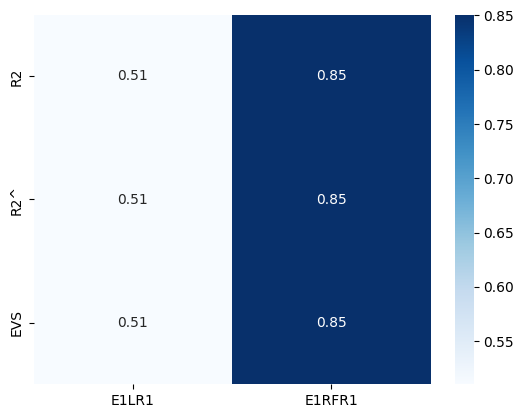

In [23]:
sns.heatmap(data = variability_values, annot = True, cmap = 'Blues')

## Business

In [41]:
business_test_tables_dict = assemble.assemble_test_tables(business_regression_test_dict['y_test'], business_regression_test_dict)

In [45]:
business_regression_test_dict['test_tables'] = business_test_tables_dict

In [46]:
assemble.assemble_error_values(business_regression_test_dict)

,B1LR1,B1RFR1
MEPE,9.841000e+00,4.600000e-02
MPE,1.369900e+01,3.771000e+00
MEAE,5.039336e+03,2.405000e+01
MAE,6.524411e+03,2.145770e+03
MSE,7.285754e+07,2.129534e+07
RMSE,8.535663e+03,4.614687e+03
STD,1.295170e+04,1.295170e+04


In [47]:
assemble.assemble_variability_values(business_regression_test_dict)

,B1LR1,B1RFR1
R2,0.565646,0.873044
R2^,0.564084,0.872587
EVS,0.565769,0.873082


assemble.assemble_error_values(loaded_dict)

# Deployment

## Economy

In [34]:
pd.DataFrame(models)

,0,1
0,LR1,{}
1,RFR1,"{'n_estimators': 20, 'criterion': 'squared_err..."


In [24]:
X, y, scaler = precprocess.preprocess_deployment_data(df_economy, 'price')

In [28]:
regressor = train.train_regression_model((X, y), 'RFR', {'n_estimators': 20, 'criterion':'squared_error'})

## Business